In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,classification_report

from imblearn.combine import SMOTETomek

In [75]:
data = pd.read_csv('recipe_site_traffic_2212.csv')
df = data.copy()
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [76]:
df.shape

(947, 8)

# Data Validation

## Observation


- The dataset consists of 947 entries with 8 columns. The columns represent various attributes of recipes, including recipe ID, calorie content, carbohydrate content, sugar content, protein content, recipe category, number of servings, and a flag indicating high traffic.

- Upon inspection, there are no duplicate rows in the dataset. However, there are missing values in several columns. Specifically, the `calories`,`carbohydrate`, `sugar`, and `protein` columns have 52 missing values each. Additionally, the "high_traffic" column has 373 missing values.

- The dataset contains a combination of numerical and categorical data. The numerical columns are `calories`, `carbohydrate`, `sugar`, and `protein`, which are represented as floating-point numbers and match their data description. The "recipe" column is an integer type, representing the recipe ID. The remaining columns, `category`,`servings`, and `high_traffic`, are categorical variables represented as objects. Servings does not match its numerical datatype as described in the table.

- The unique values in the dataset vary for each column. The `recipe` column has 947 unique values, indicating that each recipe has a unique identifier. The `calories` column has 891 unique values, while the `carbohydrate`, `sugar`, and `protein` columns have 835, 666, and 772 unique values, respectively. The `category` column does not match its description. It has 11 unique categories instead of 10 representing different recipe categories. The `servings` column has 6 unique values representing the number of servings. Lastly, the `high_traffic` column has only 1 unique value, indicating the presence of high traffic for certain recipes.

- In summary, the dataset contains recipe information with missing values in certain columns. The dataset consists of a combination of numerical and categorical data, and each column exhibits varying levels of uniqueness.

In [77]:
def data_val(df):
    # Checking for duplicated rows
    duplicated_rows = df.duplicated()
    duplicated_rows_count = duplicated_rows.sum()
    print("Number of duplicated rows:", duplicated_rows_count)    
 
    
    # Checking for null values
    null_values = df.isnull()
    null_values_count = null_values.sum()
    print("\nNumber of null values:\n", null_values_count)
    
    # Checking for missing values
    missing_values = df.isna()
    missing_values_count = missing_values.sum()
    print("\nNumber of missing values:\n", missing_values_count)
    
    
    #Check for unique values
    unique_values_per_column = df.nunique()
    print(f'\nNumber of unique values:\n{unique_values_per_column}')
    
x = data_val

In [78]:
check_data = x(df)

Number of duplicated rows: 0

Number of null values:
 recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

Number of missing values:
 recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

Number of unique values:
recipe          947
calories        891
carbohydrate    835
sugar           666
protein         772
category         11
servings          6
high_traffic      1
dtype: int64


## Data Preprocessing

The dataset underwent several preprocessing steps to ensure data consistency and completeness for further analysis.

- Firstly, a category correction was performed to address an inconsistency in the original dataset. It was observed that there were 11 distinct categories instead of the expected 10. To resolve this issue, the category 'Chicken Breast' was replaced with 'Chicken' to align similar recipe types.

- Next, an adjustment was made to the servings column. Previously, this column contained non-numeric values describing serving sizes, such as '4 as a snack' or '6 as a snack'. These descriptive values were transformed into their corresponding numerical equivalents ('4' and '6'), facilitating standardized analysis.

- Subsequently, data type conversion was applied to the servings column. The column was converted from a string/text data type to an integer data type. This conversion allows for mathematical operations and quantitative analysis related to the number of servings.

- To handle missing values in the dataset, several nutritional attributes (calories, carbohydrates, sugar, and protein) were examined. Some recipes had missing values for these attributes. To address this issue, missing values were imputed using the median value of each respective attribute. Imputing missing values with the median helps maintain data integrity and statistical representation.

- Lastly, the dataset contained missing information regarding the high traffic status of certain recipes. To account for these missing values, they were labeled as 'Other', signifying their distinction from explicitly identified high traffic recipes.

- The preprocessing steps performed on the dataset ensure its consistency, completeness, and integrity, thereby enabling accurate and reliable analyses. By addressing inconsistencies, converting data types, imputing missing values, and handling missing information, the dataset is now ready for subsequent analysis and interpretation in various research domains.

In [79]:
#convert category to category data type
print(df['category'].unique())

#Category has 11 values instead  of 10
##replace chicken breast with chicken

df['category']  = df['category'].str.replace('Chicken Breast', 'Chicken')
len(df.category.unique())

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']


10

In [80]:
#Servings has two values '4 as a snack', '6 as a snack'
replacement_servings = {'4 as a snack': '4', '6 as a snack': '6'}

for old_value, new_value in replacement_servings.items():
    df['servings'] = df['servings'].str.replace(old_value, new_value)

#df['servings'] = pd.to_numeric(df['servings'], errors='coerce')]
df['servings'] = df['servings'].astype(int)

In [81]:
df['servings'].dtype
df['servings'].unique()

array([6, 4, 1, 2])

In [82]:
#confirm dtypes
df.select_dtypes('number').columns
df.select_dtypes('object').columns

Index(['category', 'high_traffic'], dtype='object')

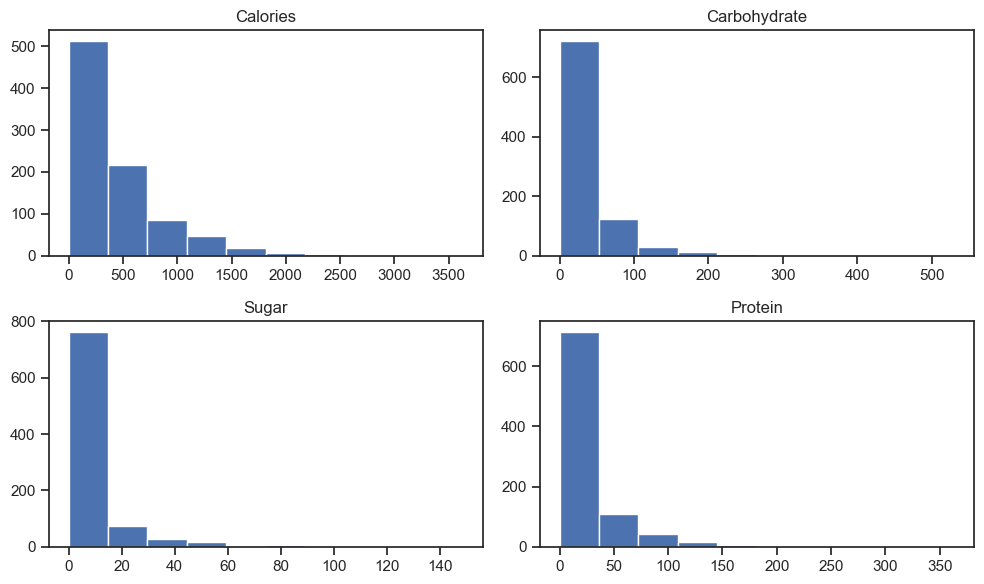

In [83]:
#View distribution of missing numerical items
figure, ax = plt.subplots(nrows=2, ncols= 2, figsize=(10,6))

ax[0, 0].hist(df['calories'])
ax[0, 0].set_title('Calories')

ax[0, 1].hist(df['carbohydrate'])
ax[0, 1].set_title('Carbohydrate')

ax[1, 0].hist(df['sugar'])
ax[1, 0].set_title('Sugar')

ax[1, 1].hist(df['protein'])
ax[1, 1].set_title('Protein')

plt.tight_layout()
plt.show()

In [84]:
#Replace missing values with the medians
df['calories'] = df['calories'].fillna(df['calories'].median())
df['carbohydrate'] = df['carbohydrate'].fillna(df['carbohydrate'].median())
df['sugar'] = df['sugar'].fillna(df['sugar'].median())
df['protein'] = df['protein'].fillna(df['protein'].median())

In [85]:
#Replace High with Other
df['high_traffic'] = df['high_traffic'].fillna('Other')
for column in df.select_dtypes('object').columns:
  print(column,len(df[column].unique()))
df.isna().sum()

category 10
high_traffic 2


recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

# EDA

## Observation

The summary report presents descriptive statistics for various nutritional components of a dataset consisting of 947 recipes. The nutritional components include calories, carbohydrate content, sugar content, protein content, and number of servings.

There are 947 observations available for each nutritional component, implying that there is no missing data after data preprocessing.

On average, a recipe contains approximately 427.85 calories, 34.32 grams of carbohydrates, 8.80 grams of sugar, 23.42 grams of protein, and is designed to serve around 3.48 portions.

The standard deviation measures the variability or dispersion of the data around the mean. The standard deviation for calories is 441.67, suggesting a relatively large variation in calorie content among the recipes. Similarly, the other nutritional components also exhibit considerable variability.

The minimum value for calories is 0.14, indicating that there is at least one recipe with an extremely low calorie content. The other nutritional components have their respective minimum values as well.

The "25%", "50%", and "75%" values correspond to the quartiles of the dataset. The 25th percentile (first quartile) represents the value below which 25% of the data falls. 25% of the recipes have calorie contents below 114.41, carbohydrate contents below 9.14 grams, sugar contents below 1.80 grams, protein contents below 3.47 grams, and servings below 2 portions. Similarly, the 50th percentile (second quartile) represents the median value, and the 75th percentile (third quartile) represents the value below which 75% of the data falls. These quartiles provide insights into the distribution and spread of the data.

The maximum calorie content is 3633.16g, indicating the presence of at least one recipe with a very high calorie content. The  respective maximum values as for carbohydrate, sugar, protein and servings are 530.42g, 148.75g, 363.36g,6.

In summary, the table provides statistical summaries of the nutritional components for a dataset of 947 recipes. These statistics offer insights into the central tendencies, variability, and range of the nutritional values, allowing for further analysis and understanding of the dataset.

In [86]:
df.drop('recipe',axis=1).describe()

,calories,carbohydrate,sugar,protein,servings
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,427.846019,34.323464,8.799641,23.416283,3.477297
std,441.673556,42.836191,14.306785,35.486699,1.732741
min,0.140000,0.030000,0.010000,0.000000,1.000000
25%,114.410000,9.135000,1.795000,3.465000,2.000000
50%,288.550000,21.480000,4.550000,10.800000,4.000000
75%,576.225000,42.590000,9.285000,28.530000,4.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000


Text(0.5, 1.0, 'Distribution of Category By Servings')

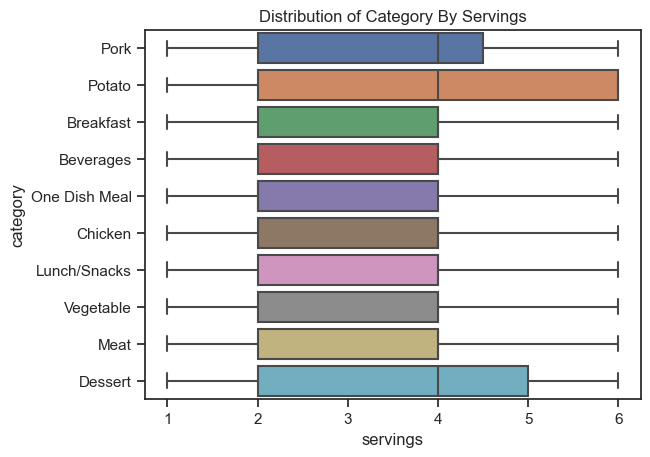

In [87]:
#view the distribution of the numerical variables
sns.boxplot(y=df['category'], x=df['servings'], orient='h')

plt.title('Distribution of Category By Servings')

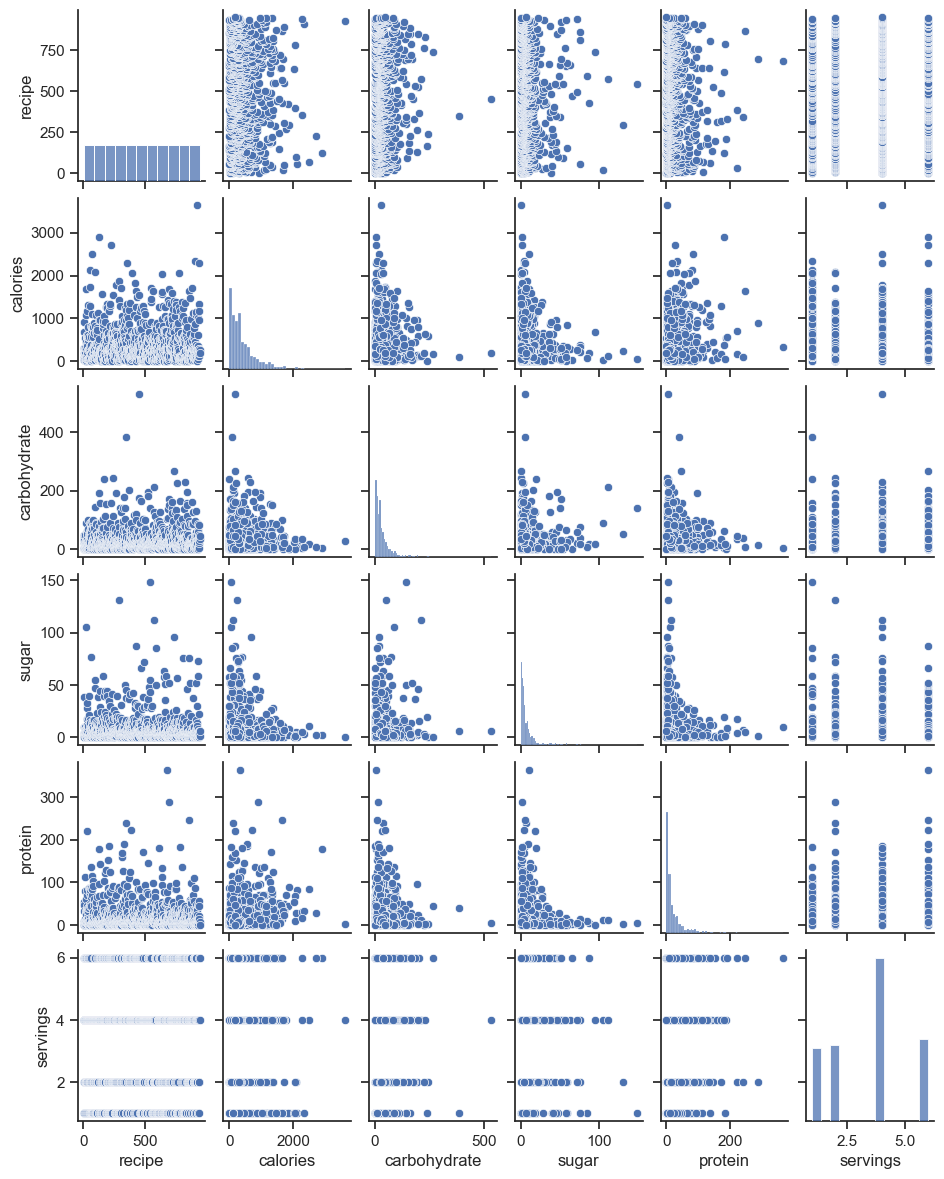

In [88]:
sns.set(style="ticks")
sns.pairplot(df,height=2, aspect=0.8)

,calories,carbohydrate,sugar,protein,servings
calories,1.000000,-0.023311,-0.091322,0.177865,-0.037250
carbohydrate,-0.023311,1.000000,0.078719,-0.036326,-0.020709
sugar,-0.091322,0.078719,1.000000,-0.092292,-0.011665
protein,0.177865,-0.036326,-0.092292,1.000000,-0.021338
servings,-0.037250,-0.020709,-0.011665,-0.021338,1.000000


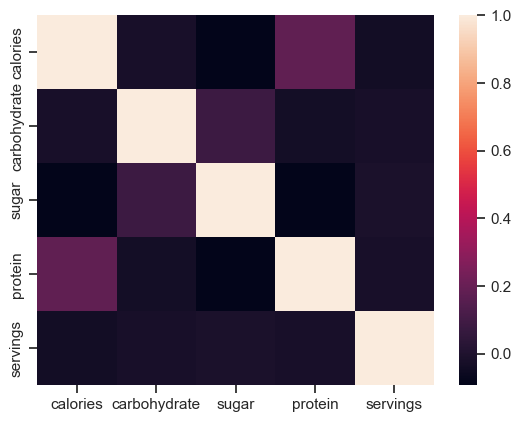

In [89]:
#Correlation between numerical variables
##no significant correlation
sns.heatmap(df.drop('recipe',axis=1).corr())
df.drop('recipe',axis=1).corr()

## Observation
- The correlation matrix indicates weak relationships between the nutritional components. Calories have a slight negative correlation with carbohydrate and sugar content, but a positive correlation with protein content. Carbohydrate content shows a weak positive correlation with sugar content. There is no significant correlation between any nutritional component and the number of servings.

- In the boxplot shows the distribution of the category by servings and shows that Deserts have the highest median

- The pairplot shows the relationship between the numerical variables

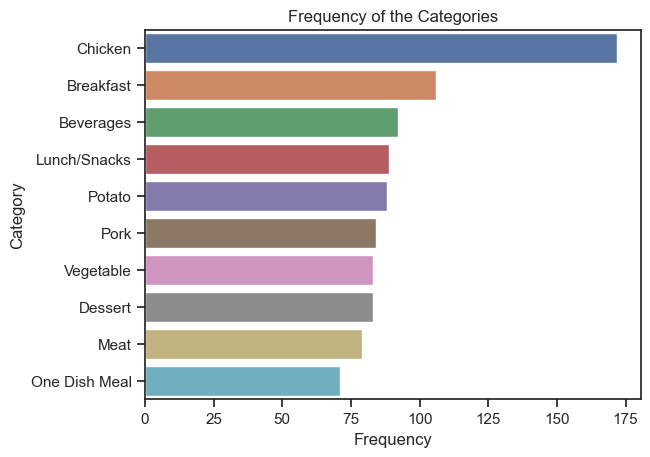

In [90]:
#Frequency of category
counts = df['category'].value_counts()
sns.barplot(y=counts.index,x=counts.values)
plt.title('Frequency of the Categories')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.show()

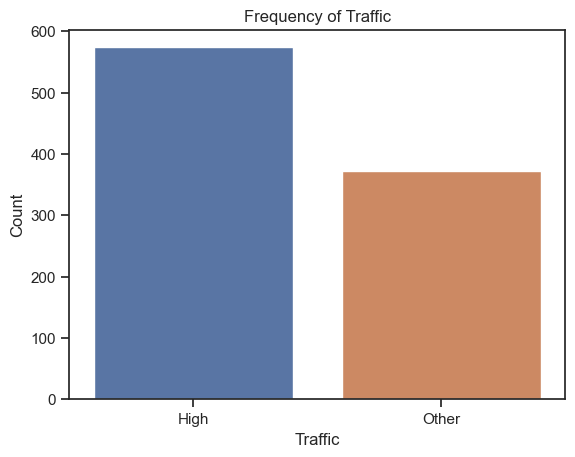

In [91]:
traffic_counts = df['high_traffic'].value_counts()
sns.barplot(x=traffic_counts.index,y=traffic_counts.values)
plt.title('Frequency of Traffic')
plt.xlabel('Traffic')
plt.ylabel('Count')
plt.show()

high_traffic
High     2035
Other    1258
Name: servings, dtype: int64


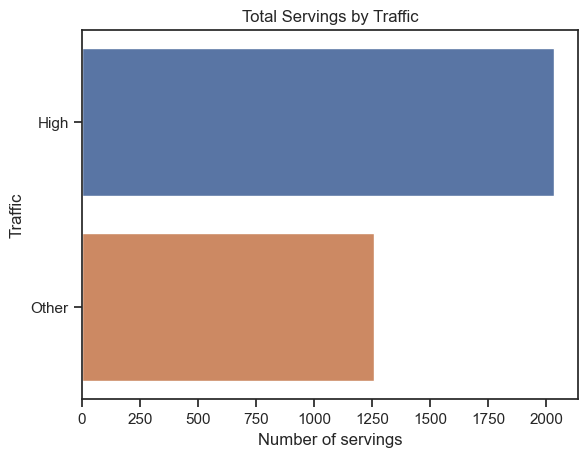

In [92]:
#Total Servings by traffic
#meals with high number of servings have more traffic
total_servings = df.groupby('high_traffic')['servings'].sum()
sns.barplot(y=total_servings.index, x=total_servings.values, orient='h')
plt.title('Total Servings by Traffic')
plt.xlabel('Number of servings')
plt.ylabel('Traffic')
print(total_servings)

category
Beverages        316
Breakfast        340
Chicken          588
Dessert          293
Lunch/Snacks     317
Meat             272
One Dish Meal    221
Pork             316
Potato           329
Vegetable        301
Name: servings, dtype: int64


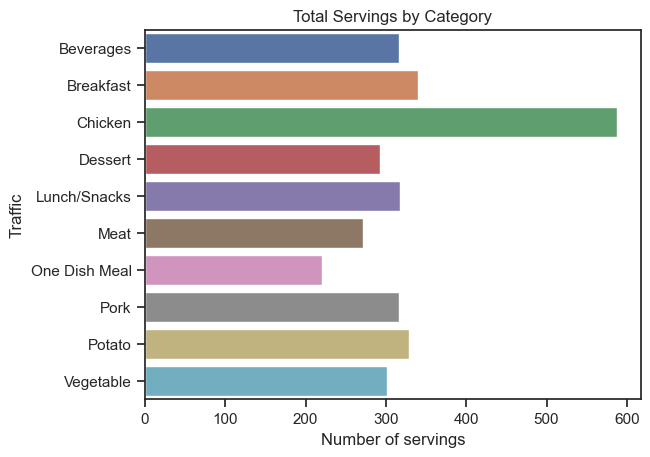

In [93]:
#Servings by Category
#Chicken serving had the highest traffic
total_cat_servings = df.groupby('category')['servings'].sum()
sns.barplot(y=total_cat_servings.index, x=total_cat_servings.values, orient='h')
plt.title('Total Servings by Category')
plt.xlabel('Number of servings')
plt.ylabel('Traffic')
print(total_cat_servings)

# Model Fitting and Evaluation

- The chosen problem revolves around predicting recipes that will generate high traffic, ultimately leading to increased website visits and subscriptions. The problem described can be treated as a binary classification task, where the goal is to predict whether a recipe will lead to high traffic or not. The objective is to develop a binary classification model that accurately identifies recipes as either high traffic or other traffic. To accomplish this, the Support Vector classification (SVC) algorithm and the RandomForest Classifier are  selected as they exhibits several desirable characteristics.

- The Random Forest Classifier is well-suited for the recipe classification task as it effectively handles high-dimensional and large feature spaces, capturing complex relationships within the data. Its robustness to outliers and binary classification capabilities align with the goal of accurately classifying recipes into high traffic or non-high traffic categories. Also, the Support Vector Classification (SVC) is an ideal choice for the recipe classification task due to its effectiveness in handling high-dimensional and large feature spaces. SVC's ability to capture complex relationships using various kernel functions facilitates accurate predictions. Additionally, SVC's robustness to outliers and its binary classification capabilities align well with the goal of classifying recipes into high traffic or non-high traffic categories.

- The metrics of  precision, recall, accuracy, f1 score have been chosen as evaluation criteria for the binary classification models due to their ability to provide insights into different aspects of the model's performance. Precision measures the accuracy of positive predictions, recall assesses the model's ability to correctly identify positive instances, and the F1-score provides a balanced measure of precision and recall. Accuracy, on the other hand, provides an overall assessment of the model's correctness in its predictions of high traffic recipes  

- SMOTETomek was chosen to handle imbalanced data because it combines the benefits of oversampling (SMOTE) and undersampling (Tomek Links). It helps to increase the representation of the minority class while removing ambiguous instances, resulting in a more balanced and better-separated dataset. This approach improves the performance of machine learning models when dealing with imbalanced data.

In [94]:
#drop the recipe column
df['high_traffic'] = df['high_traffic'].replace({'Other': 0, 'High': 1})
df = df.drop('recipe', axis=1)

In [95]:
df['high_traffic'].value_counts()

1    574
0    373
Name: high_traffic, dtype: int64

In [96]:
#One Hot Encoding
df_model = pd.get_dummies(df) 
df_model.head()

,calories,carbohydrate,sugar,protein,servings,high_traffic,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
0,288.55,21.48,4.55,10.80,6,1,0,0,0,0,0,0,0,1,0,0
1,35.48,38.56,0.66,0.92,4,1,0,0,0,0,0,0,0,0,1,0
2,914.28,42.68,3.09,2.88,1,0,0,1,0,0,0,0,0,0,0,0
3,97.03,30.56,38.63,0.02,4,1,1,0,0,0,0,0,0,0,0,0
4,27.05,1.85,0.80,0.53,4,0,1,0,0,0,0,0,0,0,0,0


In [97]:
#Seperate data into the X and y features
X = df_model.copy()
y=X.pop('high_traffic')

In [98]:
#Apply SMOTETomek to the dataset
st = SMOTETomek(random_state=24)
X_resampled, y_resampled = st.fit_resample(X, y)

## Split data into train, val and test datasets

In [99]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [100]:
#Scale the datasets
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Random Forest Model

In [101]:
rfc_model = RandomForestClassifier(random_state=42)

# Train the Random forest  model on the scaled training data
rfc_model.fit(X_train_scaled, y_train)

# Evaluate the base model on the scaled validation data
y_val_pred_rfc = rfc_model.predict(X_val_scaled)
rfc_model_accuracy = rfc_model.score(X_val_scaled, y_val)

# Evaluate the base model on the scaled testing data
y_test_pred_rfc = rfc_model.predict(X_test_scaled)
rfc_model_accuracy_test = accuracy_score(y_test,y_test_pred_rfc)

print("RFC base model validation Accuracy:", rfc_model_accuracy)
print("RFC base model test Accuracy:", rfc_model_accuracy_test)

RFC base model validation Accuracy: 0.8066666666666666
RFC base model test Accuracy: 0.8211920529801324


### Classification report of the RandomForest Classifier model

In [102]:
rfc_val_report = classification_report(y_val, y_val_pred_rfc)
rfc_test_report = classification_report(y_test, y_test_pred_rfc)

print(" Random Forest base model validation Classification Report:\n", rfc_val_report)
print("Random Forest base model test Classification Report:\n", rfc_test_report)

 Random Forest base model validation Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81        76
           1       0.80      0.81      0.81        74

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.81      0.81      0.81       150

Random Forest base model test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84        81
           1       0.82      0.79      0.80        70

    accuracy                           0.82       151
   macro avg       0.82      0.82      0.82       151
weighted avg       0.82      0.82      0.82       151



### Extract Feature Importance from Random Forest Model

- By examining the feature importance scores, you can identify the most important features for the Random Forest model and gain insights into which features have the most influence on the predictions made by the model.ro

- The top 5 features that had the most significant impact on the model's predictions.are:
  - protein: This feature has the highest importance score, suggesting it has the most significant impact on the model's predictions.
  - carbohydrate: This feature is the second most important in determining the model's predictions.
  - calories: This feature is ranked third in importance.
  - sugar: This feature is ranked fourth in importance.
  - servings: This feature is ranked fifth and contributes to the model's predictions but to a lesser extent than the top four features.



Feature ranking:
1. Feature protein: importance score = 0.1630429379344175
2. Feature carbohydrate: importance score = 0.14730199827899412
3. Feature calories: importance score = 0.137228389371389
4. Feature sugar: importance score = 0.1343074040378089
5. Feature servings: importance score = 0.07799981261910573
6. Feature category_Vegetable: importance score = 0.06211822046606011
7. Feature category_Potato: importance score = 0.05289316714776211
8. Feature category_Pork: importance score = 0.05033292068380047
9. Feature category_Beverages: importance score = 0.046685197201440064
10. Feature category_Meat: importance score = 0.02951223630486758
11. Feature category_One Dish Meal: importance score = 0.02622647429130068
12. Feature category_Dessert: importance score = 0.019209514883059685
13. Feature category_Lunch/Snacks: importance score = 0.01869085383200228
14. Feature category_Chicken: importance score = 0.017388850838230434
15. Feature category_Breakfast: importance score = 0.017062

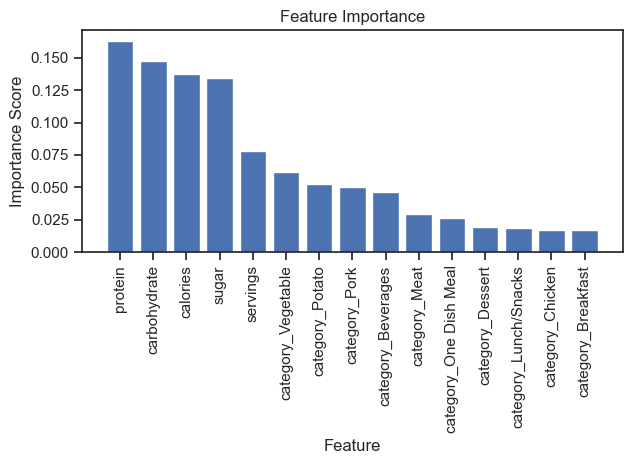

In [103]:
feature_importance = rfc_model.feature_importances_

indices = np.argsort(feature_importance)[::-1]

feature_names = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings',
       'category_Beverages', 'category_Breakfast', 'category_Chicken',
       'category_Dessert', 'category_Lunch/Snacks', 'category_Meat',
       'category_One Dish Meal', 'category_Pork', 'category_Potato',
       'category_Vegetable']

print("Feature ranking:")

for j, feature_index in enumerate(indices):
    print(f"{j + 1}. Feature {feature_names[feature_index]}: importance score = {feature_importance[feature_index]}")

plt.figure()
plt.title("Feature Importance")
plt.bar(range(len(feature_names)), [feature_importance[i] for i in indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


## Support Vector Classification Model

In [104]:
svc_model = SVC(random_state=42)

# Train the SVM model on the scaled training data
svc_model.fit(X_train_scaled, y_train)

# Evaluate the comparison model on the scaled validation data
y_val_pred = svc_model.predict(X_val_scaled)
svc_model_accuracy = svc_model.score(X_val_scaled, y_val)

# Evaluate the comparison model on the scaled testing data
y_test_pred = svc_model.predict(X_test_scaled)
svc_accuracy_test = accuracy_score(y_test,y_test_pred)

print("SVC model validation Accuracy:", svc_model_accuracy)
print("SCV model test Accuracy:", svc_accuracy_test)

SVC model validation Accuracy: 0.8066666666666666
SCV model test Accuracy: 0.8410596026490066


### Classification report of the SVC Model

In [105]:
svc_val_report = classification_report(y_val, y_val_pred)
svc_test_report = classification_report(y_test, y_test_pred)

print("SVC comparison model validation Classification Report:\n", svc_val_report)
print("SVC comparison model test Classification Report:\n", svc_test_report)

SVC comparison model validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.74      0.79        76
           1       0.76      0.88      0.82        74

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.81      0.81      0.81       150

SVC comparison model test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        81
           1       0.83      0.83      0.83        70

    accuracy                           0.84       151
   macro avg       0.84      0.84      0.84       151
weighted avg       0.84      0.84      0.84       151



### Hyperparameter tuning of the SVC model

In [106]:
# Define the comparison model with a grid of parameters to search over
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
best_svc_model = GridSearchCV(SVC(random_state=42), param_grid, cv=5)

best_svc_model.fit(X_train_scaled, y_train)

y_val_pred_svc = best_svc_model.predict(X_val_scaled)
svc_model_accuracy = accuracy_score(y_val, y_val_pred_svc)
print("SVC model validation accuracy:", svc_model_accuracy)

# Get the best parameters found by the grid search
best_params = best_svc_model.best_params_
print("Best Parameters:", best_params)

y_test_pred_svc = best_svc_model.predict(X_test_scaled)
svc_model_test_accuracy = accuracy_score(y_test, y_test_pred_svc)
print("SVC model test accuracy:", svc_model_test_accuracy)

SVC model validation accuracy: 0.8133333333333334
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
SVC model test accuracy: 0.8543046357615894


### Classification report of the tuned SVC Model

In [107]:
svc_tuned_val_report = classification_report(y_val, y_val_pred_svc)
svc_tuned_test_report = classification_report(y_test, y_test_pred_svc)

print("SVC tuned comparison  model validation Classification Report:\n", svc_val_report)
print("SVC tuned comparison  model test Classification Report:\n", svc_tuned_test_report)

SVC tuned comparison  model validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.74      0.79        76
           1       0.76      0.88      0.82        74

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.81      0.81      0.81       150

SVC tuned comparison  model test Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87        81
           1       0.85      0.83      0.84        70

    accuracy                           0.85       151
   macro avg       0.85      0.85      0.85       151
weighted avg       0.85      0.85      0.85       151



# Model Evaluation by Business Criteria

 - The company wants to predict high-traffic recipes 80% of the time.The overall accuracy of both models is above the 80% threshold. This signifies their competence in correctly classifying and predicting high traffic recipes.  The comparison of the SVC (Support Vector Classifier) comparison model and the Random Forest base model in terms of  the overall accuracy metric indicates that the tuned SVC comparison model achieved superior accuracy (85%) compared to the Random Forest base model (82%) on the test dataset.
 
- The Random Forest base model demonstrated relatively good performance in the same classification task.  For class 1 (high-traffic recipes), the precision score was 0.82, indicating that when the model predicted a recipe as "high-traffic," it was accurate 82% of the time. The recall score for class 1 was 0.79, suggesting that the model was able to capture 79% of the actual "high-traffic" recipes. The f1-score for class 1 was calculated to be 0.80. The recall score of 0.85 suggests that the model successfully identified 85% of the actual "other" recipe traffic in the dataset. The f1-score, which considers both precision and recall, was calculated to be 0.84 for class 0. 
 
- The SVC comparison model exhibited commendable performance in classifying high-traffic recipes (class 1) and non-high traffic  recipes (class 0). For class 1 (high-traffic recipes), the precision score was 0.83, indicating that when the model predicted recipes with  "high-traffic," it was accurate 83% of the time. The recall score for class 1 was 0.83, suggesting that the model captured 83% of the actual "high-traffic" recipes. The f1-score for class 1 was calculated to be 0.83. The overall accuracy of the SVC tuned model on the test dataset was 84%, indicating the percentage of correctly classified recipes among all the samples. 

In conclusion, the SVC comparison model, which was fine-tuned, outperformed the Random Forest base model in terms of precision, accuracy, recall and f1-scores. It demonstrated superior classification capability in predicting high traffic recipes. With the high accuracy of predicting high-traffic recipes, the product team can predict the recipes that would drive traffic and in turn sales and profit for the company.

# Recommendations

In the analysis of the Tasty Bytes dataset, it was revealed that the category "Chicken" had the highest number of servings among the different recipe categories. This finding indicates that chicken-based recipes tend to yield larger quantities, making them suitable for serving more people.

Considering this additional insight, the following recommendations can be made:

- Promote chicken-based recipes: Capitalize on the popularity of chicken recipes with higher servings by prominently featuring them on the platform. Highlight their versatility, taste, and ability to cater to larger gatherings. Utilize attractive visuals and descriptive content to engage users and entice them to explore these recipes further.

- Create serving size variations: While chicken recipes may have a higher number of servings, it is important to accommodate users who prefer smaller portion sizes or have dietary restrictions. Provide serving size variations for chicken recipes, allowing users to adjust the quantities to their specific needs. This customization will enhance user satisfaction and broaden the appeal of chicken-based dishes.

- Diversify chicken recipe options: Expand the variety of chicken recipes available to cater to different culinary preferences and dietary requirements. Include recipes that offer different cooking styles, flavors, and cultural influences to provide a wide range of options for users. Regularly update the chicken recipe collection to keep users engaged and encourage them to explore new dishes.

- Highlight nutritional benefits: Showcase the nutritional benefits of chicken-based recipes, such as their high protein content and potential for creating balanced meals. Educate users about the health advantages of incorporating chicken into their diet while emphasizing the flexibility to adapt the servings based on individual needs.

 - Collaborate with influencers and chefs: Partner with influencers and renowned chefs who specialize in chicken-based recipes. Collaborative content, such as videos or blog posts featuring these experts, can attract attention, build credibility, and inspire users to try new chicken dishes. Leverage social media platforms and online communities to reach a wider audience.

By capitalising on the popularity of chicken-based recipes with higher servings, Tasty Bytes can cater to the demand for versatile and crowd-pleasing meal options. Incorporating serving size variations, diversifying the chicken recipe collection, and highlighting the nutritional benefits will attract a broader user base. Collaborating with influencers and chefs will further enhance brand visibility and credibility. Continuous monitoring of user preferences and feedback will aid in refining the offerings and maintaining a competitive edge in the meal planning and recipe search market.